In [1]:
import os
import json
import numpy as np
import pandas as pd

In [2]:
# Define the paths
project_path = '../../data/libraries/project'
dependencies_path = '../../data/libraries/dependencies'

# Initialize lists to store dataframes
project_df = pd.DataFrame()
dependencies_df  = pd.DataFrame()

# Read all JSON files from project directory
for file in os.listdir(project_path):
    if file.endswith('.json'):
        # Read the JSON file
        with open(os.path.join(project_path, file), 'r') as f:
            data = json.load(f)
            df = pd.DataFrame([{
                'platform': data['platform'],
                'name': data['name'],
                'contributions_count': data['contributions_count'],
                'dependent_repos_count': data['dependent_repos_count'],
                'dependents_count': data['dependents_count'],
                'forks': data['forks'],
                'rank': data['rank'],
                'stars': data['stars']
            }])
        
        # Concatenate to the main dataframe
        project_df = pd.concat([project_df, df], ignore_index=True)



In [3]:
# Read all CSV files from dependencies directory
for file in os.listdir(dependencies_path):
    if file.endswith('.json'):
        with open(os.path.join(dependencies_path, file), 'r') as f:
            data = json.load(f)
            df = pd.DataFrame([{
                'platform': data['platform'],
                'name': data['name'],
                'dependencies_count': len(data.get('dependencies', []))
            }])
        dependencies_df = pd.concat([dependencies_df, df], ignore_index=True)

# Display the first few rows of both dataframes
print("Project DataFrame:")
print(project_df.head())
print("\nDependencies DataFrame:")
print(dependencies_df.head())

Project DataFrame:
  platform                                           name  \
0      NPM  @scandipwa/scandipwa-development-toolkit-core   
1      NPM                    react-native-usb-serialport   
2      NPM         @stdlib/stats-base-dists-binomial-mean   
3      NPM                              @arcteryx/js-i18n   
4     Pypi                                     ae-literal   

   contributions_count  dependent_repos_count  dependents_count  forks  rank  \
0                    0                      0                 4      0     7   
1                    0                      1                 3     24     9   
2                    1                      7                 8      0    11   
3                    0                      0                 0      0     6   
4                    0                      1                 5      0     9   

   stars  
0      0  
1     26  
2      1  
3      0  
4      0  

Dependencies DataFrame:
  platform               name  dependencie

In [2]:
# Read versions_major_versions_age.csv
versions_major_versions_age_df = pd.read_csv('../../data/versions_major_versions_age.csv')

# Display the first few rows of the dataframe
print("Version And Package Age DataFrame: {}".format(versions_major_versions_age_df.shape))
print(versions_major_versions_age_df.head())

Version And Package Age DataFrame: (4090125, 5)
  system_name     package_name  version_count  package_age_days  \
0       CARGO          A-Mazed              1                 0   
1       CARGO     A2VConverter              2                 0   
2       CARGO          ABC-ECS              7               230   
3       CARGO  ABC_Game_Engine              3                 0   
4       CARGO     ABC_lumenpyx              1                 0   

   major_version_count  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  


In [3]:
import pickle

# Save the DataFrame to a zip file
versions_major_versions_age_df.to_csv('../../data/processed/version_counts.zip', compression={'method': 'zip', 'compresslevel': 9})

In [2]:
# Save the dataframes to pickle files
project_df.to_pickle('../../data/processed/project_data.pkl')
dependencies_df.to_pickle('../../data/processed/dependencies_data.pkl')

NameError: name 'project_df' is not defined

In [3]:
# Load the saved dataframes
project_df = pd.read_pickle('../../data/processed/project_data.pkl')
dependencies_df = pd.read_pickle('../../data/processed/dependencies_data.pkl')

# Read the DataFrame from the zip file 
versions_major_versions_age_df = pd.read_csv('../../data/processed/version_counts.zip')

# Display the first few rows of both dataframes to verify
print("Project DataFrame: {}".format(project_df.shape))
print(project_df.head())
print("\nDependencies DataFrame: {}".format(dependencies_df.shape))
print(dependencies_df.head())

Project DataFrame: (161674, 8)
  platform                                           name  \
0      NPM  @scandipwa/scandipwa-development-toolkit-core   
1      NPM                    react-native-usb-serialport   
2      NPM         @stdlib/stats-base-dists-binomial-mean   
3      NPM                              @arcteryx/js-i18n   
4     Pypi                                     ae-literal   

   contributions_count  dependent_repos_count  dependents_count  forks  rank  \
0                    0                      0                 4      0     7   
1                    0                      1                 3     24     9   
2                    1                      7                 8      0    11   
3                    0                      0                 0      0     6   
4                    0                      1                 5      0     9   

   stars  
0      0  
1     26  
2      1  
3      0  
4      0  

Dependencies DataFrame: (161671, 3)
  platform        

In [4]:
# Merge project_df and dependencies_df on platform and name with inner join
merged_df = pd.merge(project_df, dependencies_df, on=['platform', 'name'], how='inner')
# Convert platform to uppercase to match system_name in version_counts_df
merged_df['platform'] = merged_df['platform'].str.upper()

# Merge with version_counts_df
merged_df = pd.merge(
    merged_df,
    versions_major_versions_age_df,
    left_on=['platform', 'name'],
    right_on=['system_name', 'package_name'],
    how='inner'
)

# Drop duplicate columns
merged_df = merged_df.drop(['system_name', 'package_name'], axis=1)
# Display the first few rows to verify the merge
print("Merged DataFrame: {}".format(merged_df.shape))
print(merged_df.head())

Merged DataFrame: (159154, 13)
  platform                                           name  \
0      NPM  @scandipwa/scandipwa-development-toolkit-core   
1      NPM                    react-native-usb-serialport   
2      NPM         @stdlib/stats-base-dists-binomial-mean   
3      NPM                              @arcteryx/js-i18n   
4     PYPI                                     ae-literal   

   contributions_count  dependent_repos_count  dependents_count  forks  rank  \
0                    0                      0                 4      0     7   
1                    0                      1                 3     24     9   
2                    1                      7                 8      0    11   
3                    0                      0                 0      0     6   
4                    0                      1                 5      0     9   

   stars  dependencies_count  Unnamed: 0  version_count  package_age_days  \
0      0                  24      930384    

## Send this df to PostgreSQL

In [5]:
import sqlalchemy

In [6]:
# Create a copy of merged_df and rename columns
df_to_send_to_postgres = merged_df.copy()
df_to_send_to_postgres = df_to_send_to_postgres.rename(columns={
    'platform': 'system_name',
    'name': 'package_name'
})

# Convert system_name to uppercase to match versions_major_versions_age_df
df_to_send_to_postgres['system_name'] = df_to_send_to_postgres['system_name'].str.upper()

# Display info to verify the changes
print("Modified DataFrame shape:", df_to_send_to_postgres.shape)
print("\nColumns after renaming:", df_to_send_to_postgres.columns.tolist())
print("\nFirst few rows of the modified DataFrame:")
print(df_to_send_to_postgres.head())

Modified DataFrame shape: (159154, 13)

Columns after renaming: ['system_name', 'package_name', 'contributions_count', 'dependent_repos_count', 'dependents_count', 'forks', 'rank', 'stars', 'dependencies_count', 'Unnamed: 0', 'version_count', 'package_age_days', 'major_version_count']

First few rows of the modified DataFrame:
  system_name                                   package_name  \
0         NPM  @scandipwa/scandipwa-development-toolkit-core   
1         NPM                    react-native-usb-serialport   
2         NPM         @stdlib/stats-base-dists-binomial-mean   
3         NPM                              @arcteryx/js-i18n   
4        PYPI                                     ae-literal   

   contributions_count  dependent_repos_count  dependents_count  forks  rank  \
0                    0                      0                 4      0     7   
1                    0                      1                 3     24     9   
2                    1                      7 

In [7]:
connection_str = "postgresql{dbapi}://{user}:{pw}@{host}:{port}/{db}".format(
        dbapi='',
        # dbapi="+pg8000",
        # dbapi="+psycopg",
        user="metricsuser",
        pw="metricspassword",
        host="localhost",
        port="5432",
        db="metrics")
# print (connection_str)
engine = sqlalchemy.create_engine(connection_str)
with engine.begin() as connection:
        df_to_send_to_postgres.to_sql(con=connection,
                name='libraries',
                if_exists='append',
                index=False,
                dtype={
                    'platform': sqlalchemy.types.String(),
                    'name': sqlalchemy.types.String(),
                    'contributions_count': sqlalchemy.types.Integer(),
                    'dependent_repos_count': sqlalchemy.types.Integer(),
                    'dependents_count': sqlalchemy.types.Integer(),
                    'forks': sqlalchemy.types.Integer(),
                    'rank': sqlalchemy.types.Integer(),
                    'stars': sqlalchemy.types.Integer(),
                    'dependencies_count': sqlalchemy.types.Integer(),
                    'versions_major_versions_age': sqlalchemy.types.String()
                }
        )

## Do rest

In [5]:
# Read MTTU and MTTR data
mttu_df = pd.read_csv('../../data/mttu/mttu.csv')
mttr_df = pd.read_csv('../../data/mttr/mttr.csv')

# Display the first few rows of both dataframes
print("MTTU DataFrame: {}".format(mttu_df.shape))
print(mttu_df.head())
print("\nMTTR DataFrame: {}".format(mttr_df.shape))
print(mttr_df.head())

MTTU DataFrame: (163207, 8)
  system_name from_package_name  total_duration  out_of_date_duration  \
0       CARGO               a10             397                     0   
1       CARGO           aarch64             481                   325   
2       CARGO      aardvark-dns             618                     0   
3       CARGO            ab-av1             582                   100   
4       CARGO          ab_glyph            3084                    78   

      ratio  avg_total_duration  avg_out_of_date_duration  avg_ratio  
0  0.000000               397.0                       0.0   0.000000  
1  0.675676               481.0                     325.0   0.675676  
2  0.000000               618.0                       0.0   0.000000  
3  0.171821               582.0                     100.0   0.171821  
4  0.025292              1542.0                      39.0   0.025292  

MTTR DataFrame: (22513, 8)
  system_name from_package_name  total_duration  total_post_fix_exposure_time  

In [6]:
# Rename columns in merged_df
merged_df.rename(columns={'platform': 'system_name', 'name': 'from_package_name'}, inplace=True)
merged_df['system_name'] = merged_df['system_name'].str.upper()

# Rename columns in mttu_df and mttr_df
mttu_df.rename(columns={'avg_out_of_date_duration': 'mttu'}, inplace=True)
mttr_df.rename(columns={'avg_post_fix_exposure_time': 'mttr'}, inplace=True)

# Merge merged_df with mttu_df and mttr_df
final_df_with_mttu = pd.merge(merged_df, mttu_df[['system_name', 'from_package_name', 'mttu']], on=['system_name', 'from_package_name'], how='inner')
final_df_with_mttr = pd.merge(merged_df, mttr_df[['system_name', 'from_package_name', 'mttr']], on=['system_name', 'from_package_name'], how='inner')

final_df_with_mttu_mttr = pd.merge(final_df_with_mttu, mttr_df[['system_name', 'from_package_name', 'mttr']], on=['system_name', 'from_package_name'], how='inner')

# Display the first few rows of the final dataframe
print(final_df_with_mttu.head())
print(final_df_with_mttu.shape[0], final_df_with_mttr.shape[0])
print(final_df_with_mttu_mttr.columns)

  system_name                              from_package_name  \
0         NPM  @scandipwa/scandipwa-development-toolkit-core   
1         NPM                    react-native-usb-serialport   
2         NPM         @stdlib/stats-base-dists-binomial-mean   
3         NPM                              @arcteryx/js-i18n   
4        PYPI                                     ae-literal   

   contributions_count  dependent_repos_count  dependents_count  forks  rank  \
0                    0                      0                 4      0     7   
1                    0                      1                 3     24     9   
2                    1                      7                 8      0    11   
3                    0                      0                 0      0     6   
4                    0                      1                 5      0     9   

   stars  dependencies_count  Unnamed: 0  version_count  package_age_days  \
0      0                  24      930384             33  

## Correlations

In [12]:
# List of columns to test correlation with mttu
columns_to_test = ['contributions_count', 'dependent_repos_count', 'dependents_count', 'forks', 'rank', 'stars', 'dependencies_count', 'version_count', 'mttu']

# Initialize a dictionary to store correlation matrices
correlation_matrices = {'spearman': np.zeros((len(columns_to_test), len(columns_to_test))),
                        'pearson': np.zeros((len(columns_to_test), len(columns_to_test))),
                        'kendall': np.zeros((len(columns_to_test), len(columns_to_test)))}

# Calculate correlations for each pair of columns
for i, col1 in enumerate(columns_to_test):
    for j, col2 in enumerate(columns_to_test):
        correlation_matrices['spearman'][i, j] = final_df_with_mttu[col1].corr(final_df_with_mttu[col2], method='spearman')
        correlation_matrices['pearson'][i, j] = final_df_with_mttu[col1].corr(final_df_with_mttu[col2], method='pearson')
        correlation_matrices['kendall'][i, j] = final_df_with_mttu[col1].corr(final_df_with_mttu[col2], method='kendall')

# Display the correlation matrices in a table format
mttu_spearman_df = pd.DataFrame(correlation_matrices['spearman'], index=columns_to_test, columns=columns_to_test)
mttu_pearson_df = pd.DataFrame(correlation_matrices['pearson'], index=columns_to_test, columns=columns_to_test)
mttu_kendall_df = pd.DataFrame(correlation_matrices['kendall'], index=columns_to_test, columns=columns_to_test)

print("Spearman Correlation Matrix:")
display(mttu_spearman_df)
print("\nPearson Correlation Matrix:")
display(mttu_pearson_df)
print("\nKendall Correlation Matrix:")
display(mttu_kendall_df)

Spearman Correlation Matrix:


,contributions_count,dependent_repos_count,dependents_count,forks,rank,stars,dependencies_count,version_count,mttu
contributions_count,1.000000,0.422183,0.333022,0.880195,0.816141,0.867372,-0.032715,0.162701,-0.080630
dependent_repos_count,0.422183,1.000000,0.826344,0.392798,0.654156,0.406826,0.097864,0.295883,-0.036593
dependents_count,0.333022,0.826344,1.000000,0.315604,0.629508,0.325760,0.130444,0.322852,0.012382
forks,0.880195,0.392798,0.315604,1.000000,0.783986,0.929283,-0.054309,0.152299,-0.096607
rank,0.816141,0.654156,0.629508,0.783986,1.000000,0.824636,-0.002752,0.204435,-0.167455
stars,0.867372,0.406826,0.325760,0.929283,0.824636,1.000000,-0.056667,0.133655,-0.129301
dependencies_count,-0.032715,0.097864,0.130444,-0.054309,-0.002752,-0.056667,1.000000,0.237369,0.307006
version_count,0.162701,0.295883,0.322852,0.152299,0.204435,0.133655,0.237369,1.000000,0.025348
mttu,-0.080630,-0.036593,0.012382,-0.096607,-0.167455,-0.129301,0.307006,0.025348,1.000000



Pearson Correlation Matrix:


,contributions_count,dependent_repos_count,dependents_count,forks,rank,stars,dependencies_count,version_count,mttu
contributions_count,1.000000,0.037648,0.042115,0.864879,0.401677,0.802685,-0.075939,0.042699,-0.078723
dependent_repos_count,0.037648,1.000000,0.955022,0.032371,0.140630,0.078540,0.025165,0.025301,0.000118
dependents_count,0.042115,0.955022,1.000000,0.043097,0.140754,0.099028,0.023946,0.032068,-0.001856
forks,0.864879,0.032371,0.043097,1.000000,0.341531,0.880992,-0.100395,-0.020506,-0.076057
rank,0.401677,0.140630,0.140754,0.341531,1.000000,0.451197,-0.006062,0.131795,-0.150426
stars,0.802685,0.078540,0.099028,0.880992,0.451197,1.000000,-0.069446,0.072781,-0.075771
dependencies_count,-0.075939,0.025165,0.023946,-0.100395,-0.006062,-0.069446,1.000000,0.107614,0.100636
version_count,0.042699,0.025301,0.032068,-0.020506,0.131795,0.072781,0.107614,1.000000,-0.043722
mttu,-0.078723,0.000118,-0.001856,-0.076057,-0.150426,-0.075771,0.100636,-0.043722,1.000000



Kendall Correlation Matrix:


,contributions_count,dependent_repos_count,dependents_count,forks,rank,stars,dependencies_count,version_count,mttu
contributions_count,1.000000,0.316510,0.240583,0.761893,0.661311,0.728262,-0.022745,0.123201,-0.058088
dependent_repos_count,0.316510,1.000000,0.736203,0.301432,0.518562,0.306868,0.071575,0.213796,-0.028375
dependents_count,0.240583,0.736203,1.000000,0.231721,0.484151,0.235117,0.092281,0.226834,0.006186
forks,0.761893,0.301432,0.231721,1.000000,0.633042,0.824964,-0.039431,0.113993,-0.070858
rank,0.661311,0.518562,0.484151,0.633042,1.000000,0.668946,-0.001621,0.145723,-0.119591
stars,0.728262,0.306868,0.235117,0.824964,0.668946,1.000000,-0.040598,0.097962,-0.093360
dependencies_count,-0.022745,0.071575,0.092281,-0.039431,-0.001621,-0.040598,1.000000,0.164845,0.218040
version_count,0.123201,0.213796,0.226834,0.113993,0.145723,0.097962,0.164845,1.000000,0.017276
mttu,-0.058088,-0.028375,0.006186,-0.070858,-0.119591,-0.093360,0.218040,0.017276,1.000000


In [13]:
# List of columns to test correlation with mttr
columns_to_test = ['contributions_count', 'dependent_repos_count', 'dependents_count', 'forks', 'rank', 'stars', 'dependencies_count', 'version_count', 'mttr']

# Initialize a dictionary to store correlation matrices
correlation_matrices = {'spearman': np.zeros((len(columns_to_test), len(columns_to_test))),
                        'pearson': np.zeros((len(columns_to_test), len(columns_to_test))),
                        'kendall': np.zeros((len(columns_to_test), len(columns_to_test)))}

# Calculate correlations for each pair of columns
for i, col1 in enumerate(columns_to_test):
    for j, col2 in enumerate(columns_to_test):
        correlation_matrices['spearman'][i, j] = final_df_with_mttr[col1].corr(final_df_with_mttr[col2], method='spearman')
        correlation_matrices['pearson'][i, j] = final_df_with_mttr[col1].corr(final_df_with_mttr[col2], method='pearson')
        correlation_matrices['kendall'][i, j] = final_df_with_mttr[col1].corr(final_df_with_mttr[col2], method='kendall')

# Display the correlation matrices in a table format
mttr_spearman_df = pd.DataFrame(correlation_matrices['spearman'], index=columns_to_test, columns=columns_to_test)
mttr_pearson_df = pd.DataFrame(correlation_matrices['pearson'], index=columns_to_test, columns=columns_to_test)
mttr_kendall_df = pd.DataFrame(correlation_matrices['kendall'], index=columns_to_test, columns=columns_to_test)

print("Spearman Correlation Matrix:")
display(mttr_spearman_df)
print("\nPearson Correlation Matrix:")
display(mttr_pearson_df)
print("\nKendall Correlation Matrix:")
display(mttr_kendall_df)

Spearman Correlation Matrix:


,contributions_count,dependent_repos_count,dependents_count,forks,rank,stars,dependencies_count,version_count,mttr
contributions_count,1.000000,0.407538,0.288673,0.856183,0.842634,0.846599,0.056529,0.151756,-0.226666
dependent_repos_count,0.407538,1.000000,0.796080,0.383698,0.566637,0.360518,0.162565,0.316339,-0.175643
dependents_count,0.288673,0.796080,1.000000,0.276826,0.527289,0.252100,0.193369,0.338398,-0.136298
forks,0.856183,0.383698,0.276826,1.000000,0.806668,0.920216,0.044304,0.139336,-0.211543
rank,0.842634,0.566637,0.527289,0.806668,1.000000,0.827494,0.048610,0.160443,-0.269086
stars,0.846599,0.360518,0.252100,0.920216,0.827494,1.000000,0.027521,0.109134,-0.218776
dependencies_count,0.056529,0.162565,0.193369,0.044304,0.048610,0.027521,1.000000,0.338406,0.013570
version_count,0.151756,0.316339,0.338398,0.139336,0.160443,0.109134,0.338406,1.000000,-0.163612
mttr,-0.226666,-0.175643,-0.136298,-0.211543,-0.269086,-0.218776,0.013570,-0.163612,1.000000



Pearson Correlation Matrix:


,contributions_count,dependent_repos_count,dependents_count,forks,rank,stars,dependencies_count,version_count,mttr
contributions_count,1.000000,0.072103,0.078310,0.724377,0.392282,0.646919,0.065613,0.218357,-0.068925
dependent_repos_count,0.072103,1.000000,0.971184,0.052792,0.109699,0.082994,0.038750,0.012968,-0.016029
dependents_count,0.078310,0.971184,1.000000,0.067869,0.108368,0.098199,0.041246,0.018869,-0.016564
forks,0.724377,0.052792,0.067869,1.000000,0.271408,0.813727,0.024181,0.087846,-0.023074
rank,0.392282,0.109699,0.108368,0.271408,1.000000,0.369442,0.064773,0.164832,-0.221348
stars,0.646919,0.082994,0.098199,0.813727,0.369442,1.000000,0.056337,0.174714,-0.050688
dependencies_count,0.065613,0.038750,0.041246,0.024181,0.064773,0.056337,1.000000,0.156129,0.016707
version_count,0.218357,0.012968,0.018869,0.087846,0.164832,0.174714,0.156129,1.000000,-0.071187
mttr,-0.068925,-0.016029,-0.016564,-0.023074,-0.221348,-0.050688,0.016707,-0.071187,1.000000



Kendall Correlation Matrix:


,contributions_count,dependent_repos_count,dependents_count,forks,rank,stars,dependencies_count,version_count,mttr
contributions_count,1.000000,0.316513,0.214391,0.738372,0.693923,0.710400,0.042059,0.114589,-0.160214
dependent_repos_count,0.316513,1.000000,0.713029,0.304859,0.454272,0.282536,0.120165,0.233307,-0.128650
dependents_count,0.214391,0.713029,1.000000,0.209897,0.405795,0.187703,0.137781,0.240531,-0.094875
forks,0.738372,0.304859,0.209897,1.000000,0.663892,0.826041,0.032504,0.103777,-0.152590
rank,0.693923,0.454272,0.405795,0.663892,1.000000,0.680776,0.034709,0.115141,-0.188549
stars,0.710400,0.282536,0.187703,0.826041,0.680776,1.000000,0.020037,0.080650,-0.155921
dependencies_count,0.042059,0.120165,0.137781,0.032504,0.034709,0.020037,1.000000,0.235480,0.009129
version_count,0.114589,0.233307,0.240531,0.103777,0.115141,0.080650,0.235480,1.000000,-0.110712
mttr,-0.160214,-0.128650,-0.094875,-0.152590,-0.188549,-0.155921,0.009129,-0.110712,1.000000


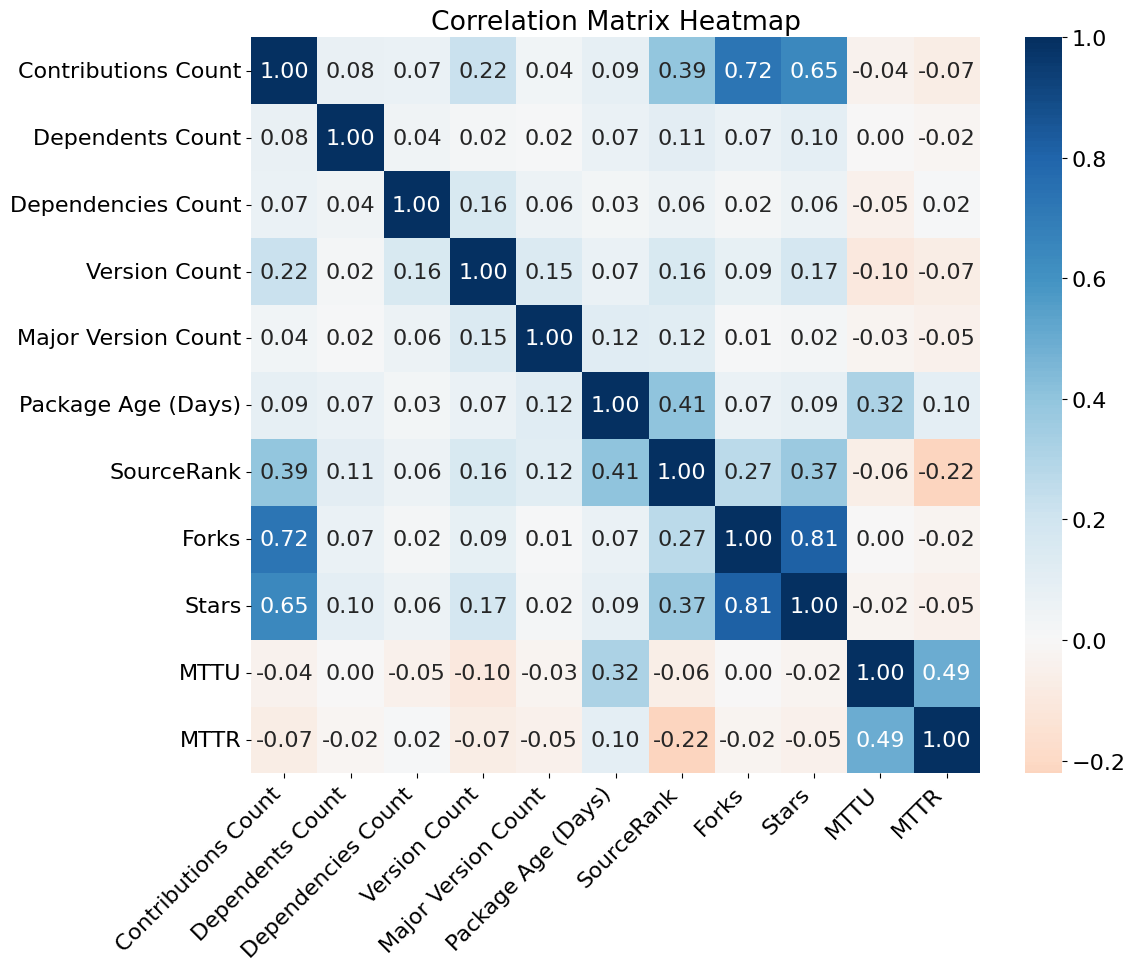

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix for final_df_with_mttu_mttr
# Removing 'dependent_repos_count' 
metrics = ['contributions_count', 'dependents_count', 'forks', 'rank', 'stars', 'dependencies_count', 'version_count', 'major_version_count', 'package_age_days', 'mttu', 'mttr']
correlation_matrix = final_df_with_mttu_mttr[metrics].corr()

# Rename each label one by one for better readability
correlation_matrix.columns = ['Contributions Count', 'Dependents Count', 'Forks', 'SourceRank', 'Stars', 'Dependencies Count', 'Version Count', 'Major Version Count', 'Package Age (Days)', 'MTTU', 'MTTR']
correlation_matrix.index = ['Contributions Count', 'Dependents Count', 'Forks', 'SourceRank', 'Stars', 'Dependencies Count', 'Version Count', 'Major Version Count', 'Package Age (Days)', 'MTTU', 'MTTR']

# Reorder the correlation matrix with the desired order
new_order = ['Contributions Count', 'Dependents Count', 'Dependencies Count', 'Version Count', 'Major Version Count', 'Package Age (Days)', 'SourceRank', 'Forks', 'Stars', 'MTTU', 'MTTR']
correlation_matrix = correlation_matrix.reindex(index=new_order, columns=new_order)

# Set font size for better readability
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', center=0, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../../results/correaltion_matrix_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Dependency Specifying Strategy

In [22]:
# Read dep_status.csv file
dep_status_df = pd.read_csv('../../data/dep_status/dep_status.csv')

# Merge dep_status_df with final_df_with_mttu
merged_with_mttu = pd.merge(final_df_with_mttu, dep_status_df, on=['system_name', 'from_package_name'], how='inner')

# Merge dep_status_df with final_df_with_mttr
merged_with_mttr = pd.merge(final_df_with_mttr, dep_status_df, on=['system_name', 'from_package_name'], how='inner')

# Categorize 'dependency_status' column
dependency_status_mapping = {
    'all_floating': 0,
    'all_pinned': 1,
    'mixed': 2
}
merged_with_mttu['dependency_status_cat'] = merged_with_mttu['dependency_status'].map(dependency_status_mapping)
merged_with_mttr['dependency_status_cat'] = merged_with_mttr['dependency_status'].map(dependency_status_mapping)

# Calculate correlation between 'dependency_status_cat' and 'mttu' and 'mttr' using different methods
correlation_methods = ['spearman', 'pearson', 'kendall']
correlation_results = {}

for method in correlation_methods:
    mttu_correlation = merged_with_mttu['dependency_status_cat'].corr(merged_with_mttu['mttu'], method=method)
    mttr_correlation = merged_with_mttr['dependency_status_cat'].corr(merged_with_mttr['mttr'], method=method)
    correlation_results[method] = {'mttu': mttu_correlation, 'mttr': mttr_correlation}

# Display the correlation results
for method, results in correlation_results.items():
    print(f"Correlation using {method}:")
    print("Correlation between 'dependency_status' and 'mttu':", results['mttu'])
    print("Correlation between 'dependency_status' and 'mttr':", results['mttr'])
    print()

Correlation using spearman:
Correlation between 'dependency_status' and 'mttu': 0.15352493526426683
Correlation between 'dependency_status' and 'mttr': -0.08181994147321954

Correlation using pearson:
Correlation between 'dependency_status' and 'mttu': 0.06712800179144453
Correlation between 'dependency_status' and 'mttr': -0.07545372043254785

Correlation using kendall:
Correlation between 'dependency_status' and 'mttu': 0.12612855684925406
Correlation between 'dependency_status' and 'mttr': -0.0654693785753345



In [23]:
from scipy.stats import ttest_ind

# List of columns to test against 'mttu'
columns_to_test = ['contributions_count', 'dependent_repos_count', 'dependents_count', 'forks', 'rank', 'stars', 'dependencies_count']

# Initialize a dictionary to store t-test results
t_test_results = {}

# Perform t-test for each column against 'mttu'
for column in columns_to_test:
    t_stat, p_value = ttest_ind(final_df_with_mttu[column], final_df_with_mttu['mttu'])
    t_test_results[column] = {'t_stat': t_stat, 'p_value': p_value}

# Display the t-test results
for column, results in t_test_results.items():
    print(f"T-test between '{column}' and 'mttu':")
    print("T-statistic:", results['t_stat'])
    print("P-value:", results['p_value'])
    print()

T-test between 'contributions_count' and 'mttu':
T-statistic: -146.11017244976776
P-value: 0.0

T-test between 'dependent_repos_count' and 'mttu':
T-statistic: -58.803626341553816
P-value: 0.0

T-test between 'dependents_count' and 'mttu':
T-statistic: -15.506431244822318
P-value: 3.2854063781367784e-54

T-test between 'forks' and 'mttu':
T-statistic: 57.209015242597594
P-value: 0.0

T-test between 'rank' and 'mttu':
T-statistic: -264.4348873802506
P-value: 0.0

T-test between 'stars' and 'mttu':
T-statistic: 89.7720279211166
P-value: 0.0

T-test between 'dependencies_count' and 'mttu':
T-statistic: -262.1335841918187
P-value: 0.0



In [24]:
# Perform t-test for 'dependency_status_cat' against 'mttu'
t_stat_mttu, p_value_mttu = ttest_ind(merged_with_mttu['dependency_status_cat'], merged_with_mttu['mttu'])

# Perform t-test for 'dependency_status_cat' against 'mttr'
t_stat_mttr, p_value_mttr = ttest_ind(merged_with_mttr['dependency_status_cat'], merged_with_mttr['mttr'])

# Display the t-test results
print("T-test between 'dependency_status_cat' and 'mttu':")
print("T-statistic:", t_stat_mttu)
print("P-value:", p_value_mttu)
print()

print("T-test between 'dependency_status_cat' and 'mttr':")
print("T-statistic:", t_stat_mttr)
print("P-value:", p_value_mttr)
print()

T-test between 'dependency_status_cat' and 'mttu':
T-statistic: -267.98063310395884
P-value: 0.0

T-test between 'dependency_status_cat' and 'mttr':
T-statistic: -136.09529862634326
P-value: 0.0



## Regression

In [22]:
import statsmodels.api as sm

# Define the independent variables (X) and the dependent variable (y)
X = final_df_with_mttu[['contributions_count', 'dependent_repos_count', 'dependents_count', 'forks', 'rank', 'stars', 'dependencies_count', 'major_version_count', 'package_age_days']]
y = final_df_with_mttu['mttu']

# Add a constant to the independent variables matrix
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display the summary of the regression analysis
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   mttu   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     1399.
Date:                Wed, 26 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:25:38   Log-Likelihood:            -1.1840e+06
No. Observations:              159154   AIC:                         2.368e+06
Df Residuals:                  159144   BIC:                         2.368e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   330.59

In [23]:
# Define the independent variables (X) and the dependent variable (y)
X = final_df_with_mttr[['contributions_count', 'dependent_repos_count', 'dependents_count', 'forks', 'rank', 'stars', 'dependencies_count', 'major_version_count', 'package_age_days']]
y = final_df_with_mttr['mttr']

# Add a constant to the independent variables matrix
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display the summary of the regression analysis
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   mttr   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     264.6
Date:                Wed, 26 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:26:12   Log-Likelihood:            -1.6318e+05
No. Observations:               22175   AIC:                         3.264e+05
Df Residuals:                   22165   BIC:                         3.265e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   511.50